In [81]:
import torch
import torchvision
import torchmetrics
import pathlib
import matplotlib.pyplot as plt
import os
import time

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [83]:
main_path = pathlib.Path("data/pizza_steak_sushi/")
train_path = main_path / "train"
test_path  = main_path / "test"

train_path, test_path

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [84]:
# Create simple transform
transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),  # convert to tensor in the range [0, 1]
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # across each color channel
        std=[0.229, 0.224, 0.225]
    ) 
])

In [85]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [86]:
# Get the transforms associated with the pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [87]:
train_data = torchvision.datasets.ImageFolder(root=train_path, transform=auto_transforms, target_transform=None)
test_data  = torchvision.datasets.ImageFolder(root=test_path,  transform=auto_transforms, target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

In [88]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [89]:
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

$$
\text{Output size} = \left\lfloor \frac{\text{Input size} + 2 \times \text{Padding} - \text{Kernel size}}{\text{Stride}} \right\rfloor + 1
$$


In [90]:
torchinfo.summary(
    model,
    input_size=(1, 3, 64, 64),
	col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
	row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 64, 64]       [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 64, 64]       [1, 1280, 2, 2]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 64, 64]       [1, 32, 32, 32]      --                   True
│    │    └─Conv2d (0)                                       [1, 3, 64, 64]       [1, 32, 32, 32]      864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 32, 32]      [1, 32, 32, 32]      64                   True
│    │    └─SiLU (2)                                         [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
│    └─Sequential (1)                                        [1, 32, 32, 32]      [1, 16, 32, 

In [91]:
for param in model.parameters():
    param.requires_grad = False # freeze all parameters

In [92]:
output_shape = len(class_names)  # number of classes (3 in this case)

# Recreate the classifier layer then send it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, out_features=output_shape, bias=True)
).to(device)

In [93]:
torchinfo.summary(
    model,
    input_size=(1, 3, 64, 64),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 64, 64]       [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 64, 64]       [1, 1280, 2, 2]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 64, 64]       [1, 32, 32, 32]      --                   False
│    │    └─Conv2d (0)                                       [1, 3, 64, 64]       [1, 32, 32, 32]      (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 32, 32]      [1, 32, 32, 32]      (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 32, 32]      [1, 32, 32, 32]      --                   --
│    └─Sequential (1)                                        [1, 32, 32, 32]      [1, 1

In [94]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

NUM_WORKERS

16

In [95]:
train_dl = torch.utils.data.DataLoader(
    dataset=train_data,
	batch_size=BATCH_SIZE,
	shuffle=True,
	num_workers=NUM_WORKERS
)

test_dl = torch.utils.data.DataLoader(
    dataset=test_data,
	batch_size=BATCH_SIZE,
	shuffle=False,
	num_workers=NUM_WORKERS
)

train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x1c92d5ace90>,
 <torch.utils.data.dataloader.DataLoader at 0x1c92d5c1a10>)

In [96]:
len(train_dl), len(test_dl)

(8, 3)

In [97]:
list(train_dl)[0][0].shape

torch.Size([32, 3, 224, 224])

In [98]:
def training(model, train_dl, optimizer, loss_fn, accuracy_fn):
	train_loss, train_acc = 0, 0

	model.train()
	for X,y in train_dl:
		X, y = X.to(device), y.to(device)

		# 1. Forward pass
		y_pred = model(X)
		loss = loss_fn(y_pred, y)

		# 2. Calculate the loss/accuracy
		train_loss += loss.item()
		train_acc  += accuracy_fn(torch.softmax(y_pred, dim=1), y).item()

		# 3. Backward pass
		optimizer.zero_grad()
		loss.backward()

		# 4. Optimizer step
		optimizer.step()

	return train_loss / len(train_dl), train_acc / len(train_dl)

In [99]:
def testing(model, test_dl, loss_fn, accuracy_fn):
	test_loss, test_acc = 0, 0
	
	model.eval()
	for X,y in test_dl:
		X, y = X.to(device), y.to(device)

		# 1. Forward pass
		with torch.inference_mode():
			y_pred = model(X)
			loss = loss_fn(y_pred, y)

		# 2. Calculate the loss/accuracy
		test_loss += loss.item()
		test_acc  += accuracy_fn(torch.softmax(y_pred, dim=1), y).item()

	return test_loss / len(test_dl), test_acc / len(test_dl)

In [100]:
def loop(model, train_dl, test_dl, optimizer, loss_fn, accuracy_fn, epochs = 3):
	results = {
		"train_loss": [],
		"train_acc":  [],
		"test_loss":  [],
		"test_acc":   []
	}

	start = time.time()
	for epoch in range(epochs):
		#-- Training
		train_epoch_loss, train_epoch_acc = training(
			model=model,
			train_dl=train_dl,
			optimizer=optimizer,
			loss_fn=loss_fn,
			accuracy_fn=accuracy_fn
		)

		#-- Testing
		test_epoch_loss, test_epoch_acc = testing(
			model=model,
			test_dl=test_dl,
			loss_fn=loss_fn,
			accuracy_fn=accuracy_fn
		)

		#-- Update results
		results["train_loss"].append(train_epoch_loss)
		results["train_acc"].append(train_epoch_acc)
		results["test_loss"].append(test_epoch_loss)
		results["test_acc"].append(test_epoch_acc)

		#-- Print out results
		print(
			f"Epoch: {epoch+1}/{epochs} | "
			f"Train loss: {train_epoch_loss:.5f} | "
			f"Train acc: {train_epoch_acc * 100:.2f}% | "
			f"Test loss: {test_epoch_loss:.5f} | "
			f"Test acc: {test_epoch_acc * 100:.2f}%"
		)
	
	end = time.time()
	print(f"\nTotal Training time: {end - start:.2f} seconds")

	return results

In [101]:
loss_fn = torch.nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names)).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [102]:
epochs = 5

model_results = loop(
	model=model,
	train_dl=train_dl,
	test_dl=test_dl,
    optimizer=optimizer,
	loss_fn=loss_fn,
	accuracy_fn=accuracy_fn,
	epochs=epochs
)

Epoch: 1/5 | Train loss: 1.05084 | Train acc: 45.31% | Test loss: 0.87142 | Test acc: 81.34%
Epoch: 2/5 | Train loss: 0.86037 | Train acc: 72.66% | Test loss: 0.78041 | Test acc: 82.39%
Epoch: 3/5 | Train loss: 0.79393 | Train acc: 62.50% | Test loss: 0.72485 | Test acc: 87.50%
Epoch: 4/5 | Train loss: 0.65529 | Train acc: 76.56% | Test loss: 0.57164 | Test acc: 89.58%
Epoch: 5/5 | Train loss: 0.66869 | Train acc: 79.30% | Test loss: 0.57233 | Test acc: 89.58%

Total Training time: 68.74 seconds


In [103]:
model_results

{'train_loss': [1.0508377104997635,
  0.8603680655360222,
  0.7939272969961166,
  0.6552921012043953,
  0.6686868779361248],
 'train_acc': [0.453125, 0.7265625, 0.625, 0.765625, 0.79296875],
 'test_loss': [0.8714215159416199,
  0.7804147005081177,
  0.7248541514078776,
  0.57163538535436,
  0.5723260243733724],
 'test_acc': [0.8134469787279764,
  0.8238636453946432,
  0.875,
  0.8958333333333334,
  0.8958333333333334]}

In [104]:
def plot_results(results, title):
	plt.figure(figsize=(15, 5))
	plt.suptitle(title, fontsize=16)

	epochs = range(len(results["train_loss"]))

	plt.subplot(1, 2, 1)
	plt.plot(epochs, results["train_loss"], label="Train loss")
	plt.plot(epochs, results["test_loss" ], label="Test loss")
	plt.title("Model Loss")
	plt.xlabel("Epochs")
	plt.ylabel("Loss")
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs,results["train_acc" ], label="Train accuracy")
	plt.plot(epochs,results["test_acc"  ], label="Test accuracy")
	plt.title("Model Accuracy")
	plt.xlabel("Epochs")
	plt.ylabel("Accuracy")
	plt.legend()

	plt.show()

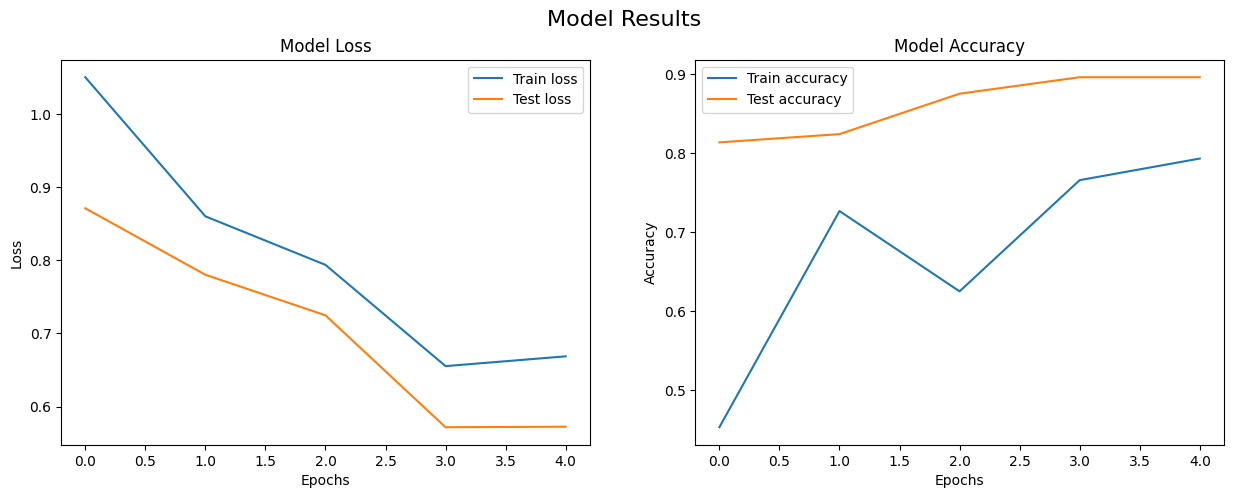

In [105]:
plot_results(results=model_results, title="Model Results")

---
### **Testing The Model**

In [108]:
from PIL import Image

def pred_and_plot_image(model, image_path,  class_names, image_size=(224, 224), transform=None, device=device):
	img = Image.open(image_path)

	if transform is None:
		transform = torchvision.transforms.Compose([
			torchvision.transforms.Resize(image_size),
			torchvision.transforms.ToTensor(),
			torchvision.transforms.Normalize(
				mean=[0.485, 0.456, 0.406],
				std=[0.229, 0.224, 0.225]
			)
		])

	#-- Predict on image
	model.to(device)
    
	model.eval()
	with torch.inference_mode():
		transformed_image = transform(img).unsqueeze(dim=0).to(device)
		target_image_pred = model(transformed_image)
	
	target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
	target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

	plt.figure()
	plt.imshow(img)
	plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
	plt.axis(False);

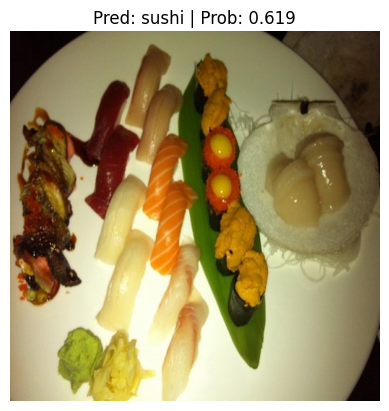

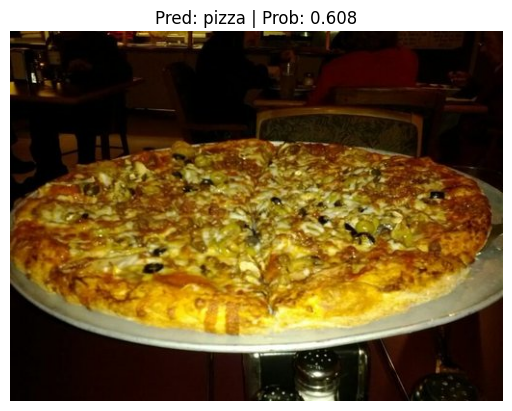

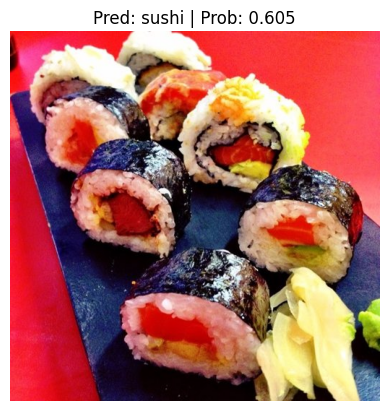

In [109]:
# Get a random list of image paths from test set
import random
from pathlib import Path

test_image_path_list = list(Path(test_path).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=3)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(
        model=model, 
        image_path=image_path,
        class_names=class_names,
        transform=weights.transforms(),
        image_size=(224, 224)
    )

#### **Predicting on a custom image**

In [110]:
import requests

# Setup custom image path
custom_image_path = main_path / "pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\pizza_steak_sushi\pizza-dad.jpeg already exists, skipping download.


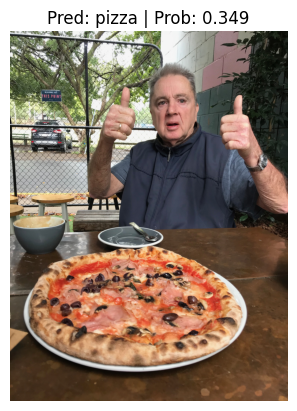

In [111]:
# Predict on custom image
pred_and_plot_image(
    model=model,
	image_path=custom_image_path,
	class_names=class_names,
	transform=weights.transforms()
)